# VistaMart Colllective Time Series Forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import LabelEncoder

Load the main csv containing the data for the VistaMart collective time series forecasting.

Since the data are not sorted, let's sort them by date and store first.

In [2]:
df = pd.read_csv('data/dataset.csv', parse_dates=['Date'], low_memory=False)

# Sort df by Date
df = df.sort_values(by=['Store', 'Date'])
display(df.head())

,Store,Date,Sales,Customers
843264,1,2013-01-02,5530,668
842155,1,2013-01-03,4327,578
841047,1,2013-01-04,4486,619
839940,1,2013-01-05,4997,635
838815,1,2013-01-07,7176,785


Let's load also the data for the individual stores and for the daily promotions.

In [3]:
stores = pd.read_csv('data/stores.csv')
display(stores.head())

,Store,Assortment,CompetitionDistance,PromoSinceWeek,PromoSinceYear,PromoInterval
0,1,Small,1270.0,NaN,NaN,NaN
1,2,Small,570.0,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,Small,14130.0,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,Large,620.0,NaN,NaN,NaN
4,5,Small,29910.0,NaN,NaN,NaN


In [4]:
promotions = pd.read_csv('data/promotions.csv', parse_dates=['Date'])
display(promotions.head())

,Store,Date
0,1,2015-07-31
1,2,2015-07-31
2,3,2015-07-31
3,4,2015-07-31
4,5,2015-07-31


We have access to singular day promotions, but we need to convert also the periodic promotions into a similar format.

In [5]:
def get_promo_dates(stores_df: pd.DataFrame) -> pd.DataFrame:
    stores_df = stores_df.copy()
    stores_df = stores_df.dropna(subset=['PromoInterval', 'PromoSinceYear', 'PromoSinceWeek'])

    month_map = {
        'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
        'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8,
        'Sept': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
    }

    promo_rows = []
    for _, row in stores_df.iterrows():
        store_id = row['Store']
        promo_year = int(row['PromoSinceYear'])
        promo_week = int(row['PromoSinceWeek'])
        months = [m.strip() for m in row['PromoInterval'].split(',')]

        promo_start_date = pd.to_datetime(f'{promo_year}-W{int(promo_week):02d}-1', format='%Y-W%W-%w')

        for year in range(promo_year, 2016):
            for month in months:
                month_num = month_map[month]
                promo_date = pd.Timestamp(year=year, month=month_num, day=1)

                if promo_date >= promo_start_date:
                    month_dates = pd.date_range(start=promo_date, end=promo_date + pd.offsets.MonthEnd(0), freq='D')
                    for d in month_dates:
                        promo_rows.append({'Store': store_id, 'Date': pd.to_datetime(d)})

    promo_df = pd.DataFrame(promo_rows)
    return promo_df

promo_dates_df = get_promo_dates(stores)
display(promo_dates_df)

,Store,Date
0,2,2010-04-01
1,2,2010-04-02
2,2,2010-04-03
3,2,2010-04-04
4,2,2010-04-05
...,...,...
256755,1115,2015-12-27
256756,1115,2015-12-28
256757,1115,2015-12-29
256758,1115,2015-12-30


Now we have to add the periodic promotions to the datafram of the daily promotions.

In [6]:
# Add promo_dates_df to promotions
promotions = pd.merge(promotions, promo_dates_df, on=['Store', 'Date'], how='outer')
promotions = promotions.drop_duplicates(subset=['Store', 'Date'])
promotions = promotions.sort_values(by=['Store', 'Date'])
display(promotions)

,Store,Date
0,1,2013-01-07
1,1,2013-01-08
2,1,2013-01-09
3,1,2013-01-10
4,1,2013-01-11
...,...,...
577877,1115,2015-12-27
577878,1115,2015-12-28
577879,1115,2015-12-29
577880,1115,2015-12-30


We can merge the main df with the stores one to add the info regarding the stores to the main df.

In [7]:
# Merge stores with df
df = pd.merge(df, stores, on='Store', how='left')
display(df)

,Store,Date,Sales,Customers,Assortment,CompetitionDistance,PromoSinceWeek,PromoSinceYear,PromoInterval
0,1,2013-01-02,5530,668,Small,1270.0,NaN,NaN,NaN
1,1,2013-01-03,4327,578,Small,1270.0,NaN,NaN,NaN
2,1,2013-01-04,4486,619,Small,1270.0,NaN,NaN,NaN
3,1,2013-01-05,4997,635,Small,1270.0,NaN,NaN,NaN
4,1,2013-01-07,7176,785,Small,1270.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
844387,1115,2015-07-27,10712,608,Large,5350.0,22.0,2012.0,"Mar,Jun,Sept,Dec"
844388,1115,2015-07-28,8093,500,Large,5350.0,22.0,2012.0,"Mar,Jun,Sept,Dec"
844389,1115,2015-07-29,7661,473,Large,5350.0,22.0,2012.0,"Mar,Jun,Sept,Dec"
844390,1115,2015-07-30,8405,502,Large,5350.0,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [8]:
df.drop(columns=['PromoSinceWeek', 'PromoSinceYear', 'PromoInterval'], inplace=True)
display(df)

,Store,Date,Sales,Customers,Assortment,CompetitionDistance
0,1,2013-01-02,5530,668,Small,1270.0
1,1,2013-01-03,4327,578,Small,1270.0
2,1,2013-01-04,4486,619,Small,1270.0
3,1,2013-01-05,4997,635,Small,1270.0
4,1,2013-01-07,7176,785,Small,1270.0
...,...,...,...,...,...,...
844387,1115,2015-07-27,10712,608,Large,5350.0
844388,1115,2015-07-28,8093,500,Large,5350.0
844389,1115,2015-07-29,7661,473,Large,5350.0
844390,1115,2015-07-30,8405,502,Large,5350.0


In [9]:
# Merge df with promotions on 'Store' and 'Date', keeping only rows present in df
df = pd.merge(df, promotions, on=['Store', 'Date'], how='left', indicator='promo_merge')
display(df)
df['Promo'] = (df['promo_merge'] == 'both').astype(int)
df.drop(columns=['promo_merge'], inplace=True)
display(df)

,Store,Date,Sales,Customers,Assortment,CompetitionDistance,promo_merge
0,1,2013-01-02,5530,668,Small,1270.0,left_only
1,1,2013-01-03,4327,578,Small,1270.0,left_only
2,1,2013-01-04,4486,619,Small,1270.0,left_only
3,1,2013-01-05,4997,635,Small,1270.0,left_only
4,1,2013-01-07,7176,785,Small,1270.0,both
...,...,...,...,...,...,...,...
844387,1115,2015-07-27,10712,608,Large,5350.0,both
844388,1115,2015-07-28,8093,500,Large,5350.0,both
844389,1115,2015-07-29,7661,473,Large,5350.0,both
844390,1115,2015-07-30,8405,502,Large,5350.0,both


,Store,Date,Sales,Customers,Assortment,CompetitionDistance,Promo
0,1,2013-01-02,5530,668,Small,1270.0,0
1,1,2013-01-03,4327,578,Small,1270.0,0
2,1,2013-01-04,4486,619,Small,1270.0,0
3,1,2013-01-05,4997,635,Small,1270.0,0
4,1,2013-01-07,7176,785,Small,1270.0,1
...,...,...,...,...,...,...,...
844387,1115,2015-07-27,10712,608,Large,5350.0,1
844388,1115,2015-07-28,8093,500,Large,5350.0,1
844389,1115,2015-07-29,7661,473,Large,5350.0,1
844390,1115,2015-07-30,8405,502,Large,5350.0,1


In [10]:
encoder = LabelEncoder()
df['Assortment'] = encoder.fit_transform(df['Assortment'])

print(encoder.inverse_transform([0, 1, 2]))
display(df.head())

['Large' 'Medium' 'Small']


,Store,Date,Sales,Customers,Assortment,CompetitionDistance,Promo
0,1,2013-01-02,5530,668,2,1270.0,0
1,1,2013-01-03,4327,578,2,1270.0,0
2,1,2013-01-04,4486,619,2,1270.0,0
3,1,2013-01-05,4997,635,2,1270.0,0
4,1,2013-01-07,7176,785,2,1270.0,1


In [11]:
df.drop(columns=['Customers'], inplace=True)

In [12]:
# FEATURES ENGINEERING COMPLETA
def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    lags = [1, 7, 14, 28]
    mas = [7, 14]
    stds = [7, 14]

    # Lag features
    for lag in lags:
        df[f'Sales_lag_{lag}'] = df.groupby('Store')['Sales'].shift(lag)

    # Rolling mean
    for window in mas:
        df[f'Sales_ma_{window}'] = (
            df.groupby('Store')['Sales']
            .apply(lambda x: x.shift(1).rolling(window).mean())
            .values
        )

    # Rolling std
    for window in stds:
        df[f'Sales_std_{window}'] = (
            df.groupby('Store')['Sales']
            .apply(lambda x: x.shift(1).rolling(window).std())
            .values
        )

    # Differenze tra lag
    df["lag_1_7_diff"] = df["Sales_lag_1"] - df["Sales_lag_7"]
    df["lag_7_14_diff"] = df["Sales_lag_7"] - df["Sales_lag_14"]

    # Rolling trend
    df["trend_7_14"] = df["Sales_ma_7"] - df["Sales_ma_14"]

    # Caratteristiche temporali
    df["month"] = df["Date"].dt.month
    df["dayofweek"] = df["Date"].dt.dayofweek
    df["day"] = df["Date"].dt.day
    df["weekofyear"] = df["Date"].dt.isocalendar().week.astype(int)
    df["quarter"] = df["Date"].dt.quarter
    df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)
    df["is_month_start"] = df["Date"].dt.is_month_start.astype(int)
    df["is_month_end"] = df["Date"].dt.is_month_end.astype(int)

    # Calcola il global_mean solo sui dati con Sales disponibili
    global_mean = df["Sales"].dropna().mean()

    # store_mean solo dove Sales è noto
    store_mean = df.groupby("Store")["Sales"].transform(lambda x: x.mean() if x.notna().all() else np.nan)
    df["store_encoded"] = 0.9 * store_mean + 0.1 * global_mean

    # Per Store + DayOfWeek
    df["Store_DOW"] = df["Store"].astype(str) + "_" + df["dayofweek"].astype(str)
    group_mean = df.groupby("Store_DOW")["Sales"].transform(lambda x: x.mean() if x.notna().all() else np.nan)
    df["store_dow_encoded"] = 0.9 * group_mean + 0.1 * global_mean
    df.drop(columns=["Store_DOW"], inplace=True)

    df.reset_index(drop=True, inplace=True)
    return df


In [13]:
df = feature_engineering(df)
print(df.Sales.isna().sum())
display(df.head())

0


,Store,Date,Sales,Assortment,CompetitionDistance,Promo,Sales_lag_1,Sales_lag_7,Sales_lag_14,Sales_lag_28,...,month,dayofweek,day,weekofyear,quarter,is_weekend,is_month_start,is_month_end,store_encoded,store_dow_encoded
0,1,2013-01-02,5530,2,1270.0,0,NaN,NaN,NaN,NaN,...,1,2,2,1,1,0,0,0,4978.737857,4795.692338
1,1,2013-01-03,4327,2,1270.0,0,5530.0,NaN,NaN,NaN,...,1,3,3,1,1,0,0,0,4978.737857,4707.606268
2,1,2013-01-04,4486,2,1270.0,0,4327.0,NaN,NaN,NaN,...,1,4,4,1,1,0,0,0,4978.737857,4949.383987
3,1,2013-01-05,4997,2,1270.0,0,4486.0,NaN,NaN,NaN,...,1,5,5,1,1,1,0,0,4978.737857,5144.224563
4,1,2013-01-07,7176,2,1270.0,1,4997.0,NaN,NaN,NaN,...,1,0,7,2,1,0,0,0,4978.737857,5355.723304


We finished the preprocessing of the data, now we can split the data into train and test sets.

In [14]:
def split_dataset(df):
    df = df.copy()
    train = df[df['Date'] < '2015-06-20']
    test = df[df['Date'] >= '2015-06-20']

    X_train, y_train = train.drop(columns='Sales'), train['Sales']
    X_test, y_test = test.drop(columns='Sales'), test['Sales']

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = split_dataset(df)

It is important to find the best parameters for the XGBoost model, so we can use Optuna to find the best parameters which could minimize the RMSE.

In [15]:
import optuna

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'random_state': 42,
        'n_jobs': -1,
        'tree_method': 'hist',
    }

    model = XGBRegressor(**params)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, preds)

    return rmse

In [16]:
import json

try:
    with open('best_params.json', 'r') as f:
        best_params = json.load(f)
except FileNotFoundError:
    best_params = None    

if not best_params:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    best_params = study.best_params
print(f"Best parameters: {best_params}")

Best parameters: {'n_estimators': 475, 'max_depth': 9, 'learning_rate': 0.22594731375525895, 'subsample': 0.9841937224705313, 'colsample_bytree': 0.8115993503676006, 'min_child_weight': 9, 'gamma': 1.0508620811373048, 'reg_alpha': 0.2682513430967105, 'reg_lambda': 1.962135997883376, 'tree_method': 'hist', 'random_state': 42, 'n_jobs': -1}


In [17]:
best_params['tree_method'] = 'hist'
best_params['random_state'] = 42
best_params['n_jobs'] = -1

model = XGBRegressor(**best_params)

X_trainC = X_train.copy()
X_testC = X_test.copy()

X_trainC.drop(columns=['Date'], inplace=True)
X_testC.drop(columns=['Date'], inplace=True)

model.fit(X_trainC, y_train,
    eval_set=[(X_testC, y_test)],
    verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8115993503676006, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=1.0508620811373048, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.22594731375525895,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=9, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=475, n_jobs=-1,
             num_parallel_tree=None, ...)

In [18]:
with open('best_params.json', 'w') as f:
    json.dump(best_params, f, indent=4)

In [19]:
TR = X_train.copy()
TR['Sales'] = y_train

TE = X_test.copy()
TE['Sales'] = y_test

print(len(TR), len(TE))

804110 40282


In [20]:
display(TE)

,Store,Date,Assortment,CompetitionDistance,Promo,Sales_lag_1,Sales_lag_7,Sales_lag_14,Sales_lag_28,Sales_ma_7,...,dayofweek,day,weekofyear,quarter,is_weekend,is_month_start,is_month_end,store_encoded,store_dow_encoded,Sales
745,1,2015-06-20,2,1270.0,0,4202.0,3695.0,5809.0,4431.0,4452.571429,...,5,20,25,2,1,0,0,4978.737857,5144.224563,4097
746,1,2015-06-22,2,1270.0,0,4097.0,4256.0,5384.0,5280.0,4510.000000,...,0,22,26,2,0,0,0,4978.737857,5355.723304,3846
747,1,2015-06-23,2,1270.0,0,3846.0,5518.0,4183.0,5235.0,4451.428571,...,1,23,26,2,0,0,0,4978.737857,4912.615608,3762
748,1,2015-06-24,2,1270.0,0,3762.0,4852.0,4071.0,4735.0,4200.571429,...,2,24,26,2,0,0,0,4978.737857,4795.692338,3346
749,1,2015-06-25,2,1270.0,0,3346.0,4000.0,4102.0,3755.0,3985.428571,...,3,25,26,2,0,0,0,4978.737857,4707.606268,3533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,1115,2015-07-27,0,5350.0,1,6897.0,7264.0,5844.0,5463.0,6089.428571,...,0,27,31,3,0,0,0,6367.774348,7012.187367,10712
844388,1115,2015-07-28,0,5350.0,1,10712.0,6083.0,7164.0,5015.0,6582.000000,...,1,28,31,3,0,0,0,6367.774348,5964.964116,8093
844389,1115,2015-07-29,0,5350.0,1,8093.0,5074.0,10598.0,5549.0,6869.142857,...,2,29,31,3,0,0,0,6367.774348,5910.990065,7661
844390,1115,2015-07-30,0,5350.0,1,7661.0,5342.0,7562.0,6676.0,7238.714286,...,3,30,31,3,0,0,0,6367.774348,5983.356268,8405


In [21]:
TE.iloc[:, 7:] = np.nan  # Set future features to NaN for test set
display(TE)
DT = pd.concat([TR, TE], ignore_index=True)

C:\Users\giuseppe.bellamacina\AppData\Local\Temp\ipykernel_9404\1874926636.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  TE.iloc[:, 7:] = np.nan  # Set future features to NaN for test set
C:\Users\giuseppe.bellamacina\AppData\Local\Temp\ipykernel_9404\1874926636.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  TE.iloc[:, 7:] = np.nan  # Set future features to NaN for test set
C:\Users\giuseppe.bellamacina\AppData\Local\Temp\ipykernel_9404\1874926636.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan' has dtype incompatible with int32, please explicitly cast to a compatible dt

,Store,Date,Assortment,CompetitionDistance,Promo,Sales_lag_1,Sales_lag_7,Sales_lag_14,Sales_lag_28,Sales_ma_7,...,dayofweek,day,weekofyear,quarter,is_weekend,is_month_start,is_month_end,store_encoded,store_dow_encoded,Sales
745,1,2015-06-20,2,1270.0,0,4202.0,3695.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
746,1,2015-06-22,2,1270.0,0,4097.0,4256.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
747,1,2015-06-23,2,1270.0,0,3846.0,5518.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
748,1,2015-06-24,2,1270.0,0,3762.0,4852.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
749,1,2015-06-25,2,1270.0,0,3346.0,4000.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,1115,2015-07-27,0,5350.0,1,6897.0,7264.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
844388,1115,2015-07-28,0,5350.0,1,10712.0,6083.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
844389,1115,2015-07-29,0,5350.0,1,8093.0,5074.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
844390,1115,2015-07-30,0,5350.0,1,7661.0,5342.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
print(len(DT))
DT = feature_engineering(DT)
print(len(DT))
print(DT.Sales.isna().sum())
display(DT.tail())

844392
844392
40282


,Store,Date,Assortment,CompetitionDistance,Promo,Sales_lag_1,Sales_lag_7,Sales_lag_14,Sales_lag_28,Sales_ma_7,...,dayofweek,day,weekofyear,quarter,is_weekend,is_month_start,is_month_end,store_encoded,store_dow_encoded,Sales
844387,1115,2015-07-27,0,5350.0,1,NaN,NaN,NaN,NaN,NaN,...,0,27,31,3,0,0,0,NaN,NaN,NaN
844388,1115,2015-07-28,0,5350.0,1,NaN,NaN,NaN,NaN,NaN,...,1,28,31,3,0,0,0,NaN,NaN,NaN
844389,1115,2015-07-29,0,5350.0,1,NaN,NaN,NaN,NaN,NaN,...,2,29,31,3,0,0,0,NaN,NaN,NaN
844390,1115,2015-07-30,0,5350.0,1,NaN,NaN,NaN,NaN,NaN,...,3,30,31,3,0,0,0,NaN,NaN,NaN
844391,1115,2015-07-31,0,5350.0,1,NaN,NaN,NaN,NaN,NaN,...,4,31,31,3,0,0,1,NaN,NaN,NaN


In [23]:
DT.to_csv('data/dataset_with_features.csv', index=False)

In [ ]:
def multistep_autoregressive_predict(model, data, steps=30, refit=True):
    data = data.copy()
    predictions = []

    for step in range(steps):
        data.sort_values(['Store', 'Date'], inplace=True)
        data = feature_engineering(data)

        mask = data['Sales'].isna()
        if not mask.any():
            break

        y_i = data[mask]
        print("Remaining rows to predict:", len(y_i))
        first_date = y_i['Date'].min()
        y_i = y_i[y_i['Date'] == first_date].copy()

        if y_i.empty:
            break

        X_i = y_i.drop(columns=['Sales', 'Date'])

        if refit:
            print("Refitting model with all available data...")
            train_data = data[data['Sales'].notna()]
            X_train = train_data.drop(columns=['Sales', 'Date'])
            y_train = train_data['Sales']
            model = XGBRegressor(**model.get_params())
            model.fit(X_train, y_train)

        y_pred = model.predict(X_i)

        data.loc[y_i.index, 'Sales'] = y_pred
        predictions.extend(y_pred)

    return data, np.array(predictions)

In [28]:
final_df, predictions = multistep_autoregressive_predict(model, DT, steps=len(TE))

Remaining rows to predict: 40282
Refitting model with all available data...
Remaining rows to predict: 39168
Refitting model with all available data...
Remaining rows to predict: 39136
Refitting model with all available data...
Remaining rows to predict: 38022
Refitting model with all available data...
Remaining rows to predict: 36908
Refitting model with all available data...
Remaining rows to predict: 35794
Refitting model with all available data...
Remaining rows to predict: 34680
Refitting model with all available data...
Remaining rows to predict: 33565
Refitting model with all available data...
Remaining rows to predict: 32450
Refitting model with all available data...
Remaining rows to predict: 32418
Refitting model with all available data...
Remaining rows to predict: 31303
Refitting model with all available data...
Remaining rows to predict: 30188
Refitting model with all available data...
Remaining rows to predict: 29073
Refitting model with all available data...
Remaining ro

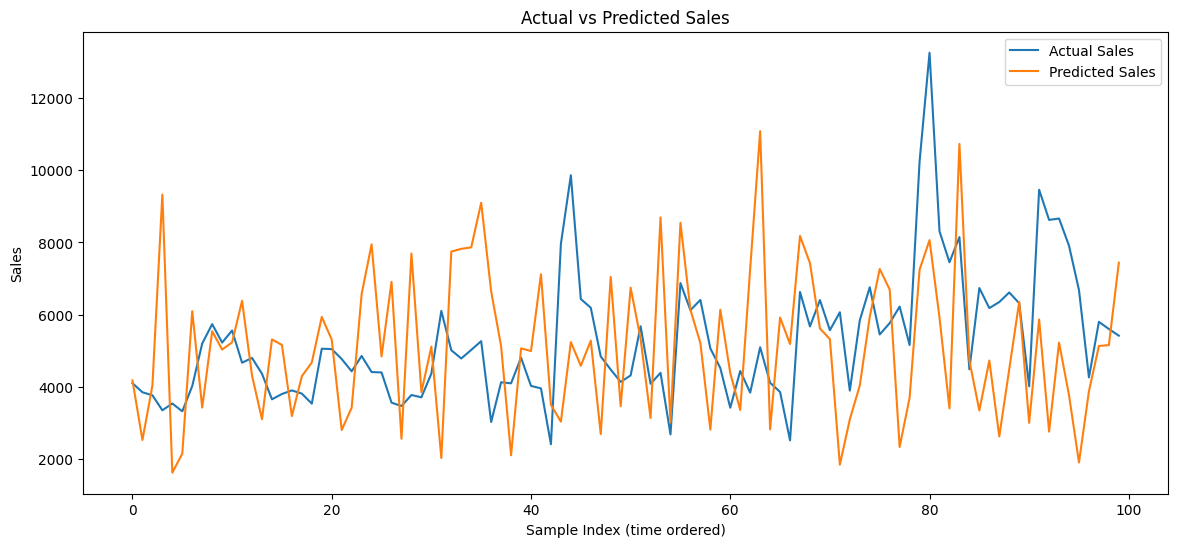

In [29]:
def plot_actual_vs_predicted(y_test, y_pred):
    plt.figure(figsize=(14,6))
    plt.plot(y_test.values, label='Actual Sales')
    plt.plot(y_pred, label='Predicted Sales')
    plt.title('Actual vs Predicted Sales')
    plt.xlabel('Sample Index (time ordered)')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()


plot_actual_vs_predicted(y_test[:100], predictions[:100])

In [30]:
print(len(predictions), "predictions made")
print(len(y_test), "actual values in test set")

40282 predictions made
40282 actual values in test set


In [31]:
rmse = root_mean_squared_error(y_test, predictions)
print(f"Test RMSE: {rmse:.2f}")
print(f"Mean Sales: {y_test.mean():.2f}")
print(f"Error percentage: {rmse / y_test.mean() * 100:.2f}%")

Test RMSE: 4241.38
Mean Sales: 6978.64
Error percentage: 60.78%
